# Obtención de Información Macroeconómica - API Banco Mundial

El Banco Mundial cuenta con una API pública de la cual se pueden descargar los principales indicadores macroecónomicos para la mayoría de países del mundo. La API es bastante completa y cuenta con indicadores que son actualizados permanentemente. <cite>[Banco Mundial][1]</cite>

En este corto ejercicio replicaremos la ya conocida relación entre la expectativa de vida de los habitantes de un país y su Producto Interno Bruto per Cápita (PIB per Cápita). Esta relación es uno de los principales argumentos de los economistas ortodoxos sobre la utilización del PIB como medida de bienestar social.

[1]: https://blogs.worldbank.org/opendata/introducing-wbgapi-new-python-package-accessing-world-bank-data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import wbgapi as wb
import seaborn as sns
import statsmodels.formula.api as smf



## Descarga y Procesamiento de Datos

Con la instrucción `pd.DataFrame(wb.source.list())` creamos un DataFrame el cual contiene toda las fuentes de información disponibles en la API junto con su fecha última actualización.

La instrucción `pd.DataFrame(wb.series.info().list())` permite obtener todas las variables disponibles en la API y en qué fuente se encuentran.

Por último, la instrucción `pd.DataFrame(wb.economy.info().list()` presenta la lista de países para los que la API cuenta con información y los códigos que deben utilizarse al momento de solicitar la información junto su información básica como ubicación geográfica y ciudad capital.

Las demás instrucciones son para guardar de manera local estos datos de manera que puedan ser utilizados como futura referencia.

In [4]:
df_sources = pd.DataFrame(wb.source.list())
df_series = pd.DataFrame(wb.series.list())
df_economies = pd.DataFrame(wb.economy.list())

# df_sources.to_excel('df_sources.xlsx', index=False)
# df_series.to_excel('df_series.xlsx', index=False)
# df_economies.to_excel('df_economies.xlsx', index=False)

Ahora busquemos las variables que tienen *GDP* como parte de su nombre

In [5]:
idx_gdp = list(map(lambda x: True if 'GDP' in x else False, df_series.value))

In [6]:
df_series[idx_gdp].sort_values(by='value')

,id,value
618,NV.AGR.TOTL.ZS,"Agriculture, forestry, and fishing, value adde..."
321,FM.LBL.BMNY.GD.ZS,Broad money (% of GDP)
231,EN.ATM.CO2E.KD.GD,CO2 emissions (kg per 2015 US$ of GDP)
237,EN.ATM.CO2E.PP.GD.KD,CO2 emissions (kg per 2017 PPP $ of GDP)
236,EN.ATM.CO2E.PP.GD,CO2 emissions (kg per PPP $ of GDP)
...,...,...
374,GC.TAX.TOTL.GD.ZS,Tax revenue (% of GDP)
706,NY.GDP.TOTL.RT.ZS,Total natural resources rents (% of GDP)
611,NE.TRD.GNFS.ZS,Trade (% of GDP)
29,BG.GSR.NFSV.GD.ZS,Trade in services (% of GDP)


Una de los principios básicos cuando se está analizando la actividad económica de un país es utilizar en valores en términos reales o por lo menos constantes; es por eso que utilizaremos la variables `NY.GDP.PCAP.KD - GDP per capita (constant 2015 US$)`, así el análisis no se verá afectado por choques inflacionarios o deflacionarios puntuales; sin embargo, estos valores no se escapan de las dinámicas de la tasa de cambio.

En las siguientes líneas, traemos la información del PIB per Cápita de todos los países correspondientes a la región `LCN`, es decir, América Latina y el Caribe.

In [8]:
code = 'NY.GDP.PCAP.KD'
idx_countries = df_economies.region == 'LCN'
countries = df_economies[idx_countries]['id'].values
df_gdp = wb.data.DataFrame(code, countries)
df_gdp.head().iloc[:, 0:10] # sólo las primeras columnas, por presentación

,YR1960,YR1961,YR1962,YR1963,YR1964,YR1965,YR1966,YR1967,YR1968,YR1969
economy,,,,,,,,,,
ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ARG,7410.305029,7687.517338,7498.840061,6986.564802,7572.231166,8241.529337,8059.450431,8187.373351,8450.037064,9126.186479
ATG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BHS,19072.904739,20103.819316,21134.587525,22243.334434,23490.758406,24853.858455,25948.805578,27203.648304,28200.664466,29436.746325
BLZ,1558.791461,1593.999864,1629.731855,1664.242945,1697.487597,1729.092008,1757.536191,1788.459135,1863.126615,1903.235521


Se puede ver que hay datos desde 1966 hasta 2022, dado que no todos tienen registros, tomemos solamente los países que tengan registros a partir de 1980.

In [9]:
pos_1980 = df_gdp.columns.get_loc('YR1980')

df_gdp = df_gdp.iloc[:, pos_1980:]
df_gdp.dropna(how='any', inplace=True)

Ahora hacemos lo mismo pero para la variable expectativa de vida, revisando las series vemos que su identificador es `SP.DYN.LE00.IN`; nótese que incluso se podrían obtener los valores diferenciados por hombres y mujeres, algo importante dependiendo de la situación del estado en cuestión (i.e., una guerra).

In [10]:
idx_exp = list(map(lambda x: True if 'expectancy' in x else False, df_series.value))
df_series[idx_exp]

,id,value
1292,SP.DYN.LE00.FE.IN,"Life expectancy at birth, female (years)"
1293,SP.DYN.LE00.IN,"Life expectancy at birth, total (years)"
1294,SP.DYN.LE00.MA.IN,"Life expectancy at birth, male (years)"


In [11]:
code = 'SP.DYN.LE00.IN'

In [12]:
idx_countries = df_economies.region == 'LCN'
countries = df_economies[idx_countries]['id'].values
df_expectancy = wb.data.DataFrame(code, countries)


En este caso vemos que no hay aún información para 2022, por lo que el filtro debe ser modificado para tener en cuenta esto

In [13]:
pos_1980 = df_expectancy.columns.get_loc('YR1980')
pos_2022 = df_expectancy.columns.get_loc('YR2022')

df_expectancy = df_expectancy.iloc[:, pos_1980:pos_2022]
df_expectancy.dropna(how='any', inplace=True)

In [14]:
df_expectancy.head().iloc[:, 0:10] # sólo las primeras columnas, por presentación

,YR1980,YR1981,YR1982,YR1983,YR1984,YR1985,YR1986,YR1987,YR1988,YR1989
economy,,,,,,,,,,
ABW,71.066,71.722,71.959,72.105,72.251,72.388,72.462,72.789,73.047,73.023
ARG,68.564,68.976,68.937,69.267,69.195,69.651,70.119,70.564,71.052,71.425
ATG,73.183,73.338,73.458,73.471,73.524,73.566,73.556,73.554,73.530,73.416
BHS,67.521,67.746,68.436,69.161,69.351,69.257,69.285,68.924,69.215,69.598
BLZ,67.756,68.068,67.955,68.140,68.640,69.462,69.704,70.198,70.781,70.724


Ahora unimos los datos de expectativa de vida con los de PIB per Cápita; pero antes debemos cambiar los nombres de la columnas para evitar confusión.

In [15]:
cols = list(map(lambda x: str.replace(x, 'YR', 'GDP_'), df_gdp.columns))
df_gdp.columns = cols

cols = list(map(lambda x: str.replace(x, 'YR', 'EXP_'), df_expectancy.columns))
df_expectancy.columns = cols

In [16]:
df_data = pd.merge(left=df_gdp, right=df_expectancy, on='economy')

## Elaboración de los Gráficos

Ahora presentemos la relación entre expectativa de vida y PIB per Cápita de manera gráfica para el año 2000. Se puede ver que los países con mayor PIB parecen tener mayor expectativa de vida, pero la relación no es clara.

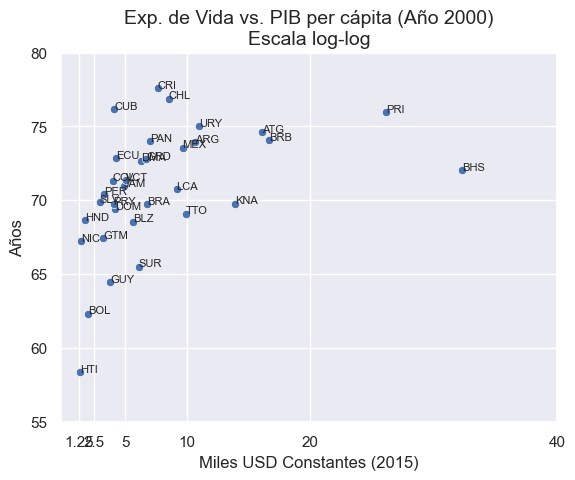

In [18]:
sns.set_theme()
ax = sns.scatterplot(df_data, x=df_data['GDP_2000'], y=df_data['EXP_2000'])
for i, r in df_data.iterrows():
    ax.text(r['GDP_2000']+0.08, r['EXP_2000'], i, size=8)

plt.ylabel('Años')
plt.xlabel('Miles USD Constantes (2015)')
plt.title('Exp. de Vida vs. PIB per cápita (Año 2000)\nEscala log-log', size=14)
plt.grid()
plt.yticks(ticks=[55, 60, 65, 70, 75, 80], labels=[55, 60, 65, 70, 75, 80])
plt.xticks(ticks=[1250, 2500, 5000, 10000, 20000, 40000], labels=[1.25, 2.5, 5, 10, 20, 40])
plt.grid()
plt.show()
plt.show()

Usemos entonces una escala logarítmica, esta permite apreciar de manera más clara cambios relativos en lugar de absolutos y agreguemos el identificador de cada país. En este gráfico se puede apreciar una relación mucho más clara.

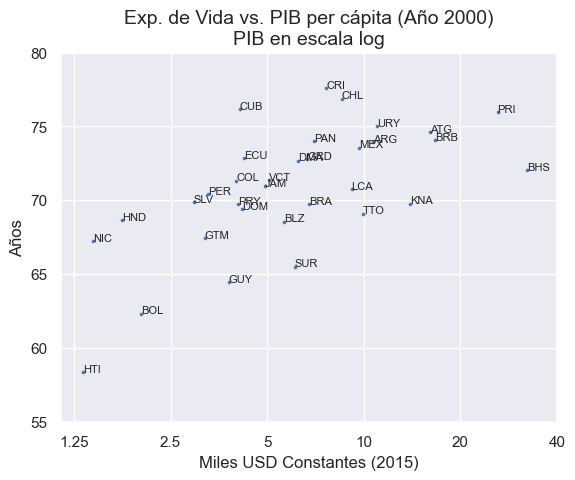

In [19]:
ax1 = sns.scatterplot(df_data, x=df_data['GDP_2000'], y=df_data['EXP_2000'], s=8)

pos_gdp = df_data.columns.get_loc('GDP_2000')
pos_exp = df_data.columns.get_loc('EXP_2000')
# Economy is the index
pos_eco = 0

for i, r in df_data.iterrows():
    ax1.text(r['GDP_2000']+0.08, r['EXP_2000'], i, size=8)

ax1.set(xscale="log")
plt.ylabel('Años')
plt.xlabel('Miles USD Constantes (2015)')
plt.title('Exp. de Vida vs. PIB per cápita (Año 2000)\nPIB en escala log', size=14)
plt.grid()
plt.yticks(ticks=[55, 60, 65, 70, 75, 80], labels=[55, 60, 65, 70, 75, 80])
plt.xticks(ticks=[1250, 2500, 5000, 10000, 20000, 40000], labels=[1.25, 2.5, 5, 10, 20, 40])
plt.grid()
plt.show()

Ahora el mismo gráfico para el año 2020. Se puede ver como algunos países han tenido un incremento tanto en PIB como en expectativa de vida; adicionalmente, la tendencia parecer ser la misma en ambos años.

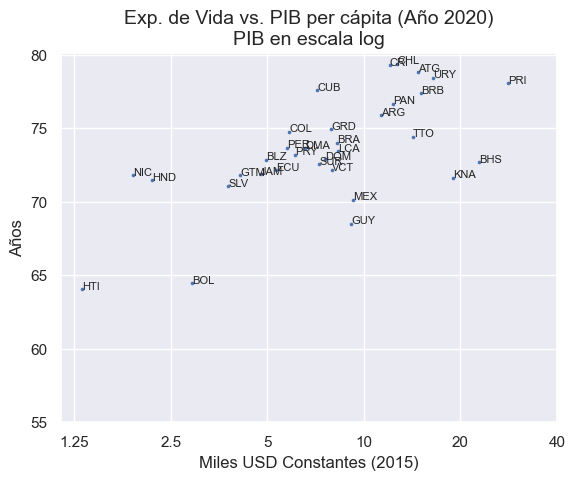

In [20]:
ax1 = sns.scatterplot(df_data, x=df_data['GDP_2020'], y=df_data['EXP_2020'], s=8)

pos_gdp = df_data.columns.get_loc('GDP_2020')
pos_exp = df_data.columns.get_loc('EXP_2020')
# Economy is the index
pos_eco = 0
ir = None
for i, r in df_data.iterrows():
    ax1.text(r['GDP_2020']+0.08, r['EXP_2020'], i, size=8)


ax1.set(xscale="log")
plt.ylabel('Años')
plt.xlabel('Miles USD Constantes (2015)')
plt.title('Exp. de Vida vs. PIB per cápita (Año 2020)\nPIB en escala log', size=14)
plt.grid()
plt.yticks(ticks=[55, 60, 65, 70, 75, 80], labels=[55, 60, 65, 70, 75, 80])
plt.xticks(ticks=[1250, 2500, 5000, 10000, 20000, 40000], labels=[1.25, 2.5, 5, 10, 20, 40])
plt.grid()
plt.savefig('exp_vs_pib',dpi=2000)

## Regresión Lineal Simple para Evaluar la Relación Expectativa de Vida vs. PIB per Cápita

Ahora planteamos un modelo de regresión lineal simple para cuantificar la intensidad de la relación entre las variables y qué tan sólida es la evidencia estadística. Al ser un modelo Lineal-Logarítmico nos está diciendo que, en promedio, cada 1% adicional de PIB per Cápita de un país de Latinoamérica en el 2000 significó un aumento **expectativa de vida aumentó en 3.48 años** (el coeficiente de np.log(GDP_2000)). Adicionalmente, el modelo explica el 38% de la **varianza de la expectativa de vida entre los países de Latinoamérica para el año 2000**. En este modelo, el intercepto corresponde a la expectativa de vida cuando la variable independiente, el **logaritmo** del PIB per Cápita, es igual a cero; es decir, cuando la variable en su escala original es igual a 1. En otras palabras, se puede interpretar como la expectativa de vida sin considerar el efecto de la **variación porcentual** del PIB per Cápita.

$$ Intercepto \implies ln(PIB) = 0 $$
$$ ln(PIB) = 0 \implies e^{ln(PIB)} = e^0 $$
$$ PIB = 1$$

Finalmente, la prueba de <cite>[**Jarque-Berra**][1]</cite> arroja un valor-p de 0.797, por lo que no se puede rechazar la hipótesis nula de residuales distribuídos normalmente; y el estadístico de <cite>[**Durbin-Watson**][2]</cite> presenta un valor de 1.456, el cual es superior al valor crítico de 1.291 para este número de observaciones y grados de libertad. En otras palabras, a pesar de su simplicidad (parsimonia en términos estadísticos), **este modelo cumple con todos los supuestos tradicionales de la Regresión Lineal**.

[1]: https://en.wikipedia.org/wiki/Jarque%E2%80%93Bera_test
[2]: https://en.wikipedia.org/wiki/Durbin%E2%80%93Watson_statistic


In [21]:
import numpy as np
model_2000 = smf.ols(formula='(EXP_2000) ~ np.log(GDP_2000)', data=df_data).fit()
model_2000.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               EXP_2000   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     20.84
Date:                Sat, 23 Dec 2023   Prob (F-statistic):           7.44e-05
Time:                        14:51:11   Log-Likelihood:                -85.058
No. Observations:                  33   AIC:                             174.1
Df Residuals:                      31   BIC:                             177.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           40.5786      6.651      6.101      0.000      27.014      54.143
np.log(GDP_2000)     3.4811      0.763      4.565      0.000       1.926       5.036
==============================================================================
Omnibus:                        0.545   Durbin-Watson:                   1.456
Prob(Omnibus):                  0.762   Jarque-Bera (JB):                0.454
Skew:                          -0.267   Prob(JB):                        0.797
Kurtosis:                       2.787   Cond. No.                         103.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Año 2020
Para finalizar, realicemos el mismo ejercicio con el año 2020; aunque disminuyó el valor del coeficiente la capacidad explicativa del modelo subió a 42% manteniendo su validez en el diagnóstico de residuales.

In [22]:
import numpy as np
model_2020 = smf.ols(formula='(EXP_2020) ~ np.log(GDP_2020)', data=df_data).fit()
model_2020.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               EXP_2020   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     24.28
Date:                Sat, 23 Dec 2023   Prob (F-statistic):           2.64e-05
Time:                        14:51:12   Log-Likelihood:                -79.606
No. Observations:                  33   AIC:                             163.2
Df Residuals:                      31   BIC:                             166.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           42.5335      6.303      6.748      0.000      29.678      55.389
np.log(GDP_2020)     3.4693      0.704      4.928      0.000       2.033       4.905
==============================================================================
Omnibus:                        2.672   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.263   Jarque-Bera (JB):                2.262
Skew:                          -0.630   Prob(JB):                        0.323
Kurtosis:                       2.761   Cond. No.                         118.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""